In [28]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer

class Adam(Optimizer):
    
    """
    Params:
    stepsize (float): the effective upperbound of the optimizer step in most cases (size of step). DEFAULT - 0.001.
    bias_m1 (float): bias for the first moment estimate. DEFAULT - 0.9
    bias_m2 (float): bias for the second uncentered moment estimate, DEFAULT - 0.999.
    epsilon (float): small number added to prevent division by zero, DEFAULT - 10e-8.
    bias_correction (bool): whether the optimizer should correct for the specified biases when taking a step. DEFAULT - TRUE.
    """
    #Initialize optimizer with parameters
    def __init__(self, params, stepsize = 0.001, bias_m1 = 0.9, bias_m2 = 0.999, epsilon = 10e-8, bias_correction = True):
        #Check if stepsizes and biases are invalid (negative)
        if stepsize < 0:
            raise ValueError("Invalid stepsize [{}]. Choose a positive stepsize".format(stepsize))
        if bias_m1 < 0 or bias_m2 < 0 and bias_correction:
            raise ValueError("Invalid bias parameters [{}, {}]. Choose positive bias parameters.".format(bias_m1, bias_m2))
        #Declare dictionary of default values for optimizer initialization
        DEFAULTS = dict(stepsize = stepsize, bias_m1 = bias_m1, bias_m2 = bias_m2, epsilon = epsilon, bias_correction = bias_correction)
        #Initialize the optimizer
        super(Adam, self).__init__(params, DEFAULTS)

    #Step method (for updating parameters)
    def step(self, closure = None):
        #Set loss to none
        loss = None
        #If the closure is set to True, set the loss to the closure function
        loss = closure() if closure != None else loss
        #Check if this is the first step - if not, increment the current step
        if not self.state["step"]:
            self.state["step"] = 1
        else:
            self.state["step"] += 1
        #Iterate over "groups" of parameters (layers of parameters in the network) to begin processing and computing the next set of params
        for param_group in self.param_groups:
            #Iterate over individual parameters
            for param in param_group["params"]:
                #Check if gradients have been computed for each parameter
                #If not - if there are no gradients - then skip the parameter
                if param.grad.data == None:
                    continue
                else: gradients = param.grad.data
                #Use Adam optimization method - first, define all the required arguments for the parameter if we are on the first step
                if self.state["step"] == 1:
                    #Set the first and second moment estimates to zeroes
                    self.state["momentum"] = torch.zeros_like(param.data)
                    self.state["rms"] = torch.zeros_like(param.data)
                #Declare variables from state - inplace methods modify state variable directly
                momentum = self.state["momentum"]
                rms = self.state["rms"]
                #Compute the first moment estimate - B_1 * m_t + (1-B_1) * grad (uncentered)
                momentum.mul_(param_group["bias_m1"]).add_(gradients * (1.0 - param_group["bias_m1"]))
                #Compute the second moment estimate - B_2 * v_t + (1-B_2) * grad^2 (uncentered)
                rms.mul_(param_group["bias_m2"]).add_(gradients.pow_(2) * (1.0 - param_group["bias_m2"]))
                #Perform bias correction if parameter is set to true
                if param_group["bias_correction"]:
                    #Perform bias correction for the first moment estimate: m_t / (1 -B_1^t)
                    momentum.divide_(1.0 - (param_group["bias_m1"] ** self.state["step"]))
                    #Perform bias correction for second moment estimate: v_t / (1 - B_2^t)
                    rms.divide_(1.0 - (param_group["bias_m2"] ** self.state["step"]))
                #Next, perform the actual update
                #Multiply the stepsize a by the quotient of the first moment estimate and the square root of the second moment estimate plus epsilon
                #In other words - theta = theta_{t-1} - a * first_estimate/(sqr(second_estimate) + epsilon)
                param.data.add_((-param_group["stepsize"]) * momentum.divide_(rms.sqrt_() + param_group["epsilon"]))
        #Return the loss
        return loss

In [24]:
#We want to test different optimizers using different optimizer evaluation functions
#Run each optimizer across a) the Rosenbrock function, b) Local Minima filled functions, c) Bowl-Shaped functions, d) Plate-Shaped functions
# and e) Functions with Steep drops

#After running each optimizer across these functions, take the average across all functions and plot to determine average performance
#Generate x data for each test - use same initialization distribution to ensure reproducibility and fairness while testing
import math

#Class to test optimizer
class OptimizerTest():
    #Initialize optimizer testing object
    def __init__(self, Optimizer, epochs, params, **opt_args):
        #Set the parameters to an initial x and y value, optimize_(var) variables will be modiifed in the optimization process via the optimizeParams() method
        self.params = params
        #Set both the initial and optimized versions of x and y to COPIES of the original parameter such as to not modify the input tensor
        self.initial_x, self.initial_y = torch.clone(self.params)
        #Save optional arguments for future object creation
        self.opt_args = opt_args
        #Save optimizer type for same purpose
        self.optimizer_type = Optimizer
        #Instantiate new Optimizer object - check if optional keyword arguments (specific arguments for the optimizer) have been provided
        if self.opt_args != {}:
            self.vals = [args for args in self.opt_args.values()]
            self.optimizer = Optimizer([self.params], *self.vals)
        else: self.optimizer = Optimizer([self.params])
        #Set both the initial and optimized versions of x and y to COPIES of the original parameter such as to not modify the input tensor
        self.initial_x, self.initial_y = torch.clone(self.params)
        #Set epochs
        self.epochs = epochs

    #Optimize the loss function on a given loss function
    def optimizeParams(self, loss_function):
        #Fit the given 3D function
        #Store losses (z values) obtained via optimizing this function
        losses = []
        points = []
        #Iterate over number of epochs
        for epoch in range(self.epochs):
            #Set all gradients to zero - this is to prevent gradient accumulation as they do not reset per epoch
            self.optimizer.zero_grad()
            #Compute the loss
            x, y = self.params
            loss = loss_function(x, y)
            #Compute the gradients
            loss.backward()
            #Run the optimizer
            self.optimizer.step()
            #Add loss to loss array - use item() for both this append and the next one to extract the raw scalar as opposed to adding the tensor
            #Adding the tensor directly causes unexpected behaviour as the optimizer directly modifies the base; thereby changing all views and raising exceptions
            losses.append(loss.item())
            #Append points to point array for visualization and evaluation
            points.append([x.item(), y.item(), loss.item()])
        #Add losses array to dictionary of all optimization functions
        #To find the name of the function given, use the .__name__ method
        self.all_losses["{}".format(loss_function.__name__)] = losses
        self.all_points["{}".format(loss_function.__name__)] = points
        
    #Method to run tests - create a new LossFunctions object, and run the optimization method on all of those functions
    def runTests(self):
        #Create dictionary of all losses
        self.all_losses = {}
        #Create dictionary of all points
        self.all_points = {}
        #Create new LossFunctions object to obtain various testing functions
        TestFunctions = LossFunctions(self.params)
        #Define list of loss functions we would like to optimize from Lossfunctions
        self.loss_opt_funcs = ["RosenbrockLoss", "BukinLoss", "BohachevskyLoss", "BoothLoss", "CamelLoss", "EasomLoss"]
        #Optimize each given loss function (call optimizeParams for each function in the list)
        for loss_func in self.loss_opt_funcs:
            func = eval('TestFunctions.{}'.format(loss_func))
            self.optimizeParams(func)
            #Reset the optimized parameters back to the initial values - this ensures that each test starts off with the same values
            self.params = torch.tensor((self.initial_x, self.initial_y), requires_grad = True, dtype = torch.float64)
            #Create a new optimizer object - each instance of the optimizer is meant to optimize one loss function
            #As the optimization task is done, create a new instance of the optimizer
            if self.opt_args != {}:
                self.vals = [args for args in self.opt_args.values()]
                self.optimizer = self.optimizer_type([self.params], *self.vals)
            else: self.optimizer = self.optimizer_type([self.params]) 
        return self.all_losses, self.all_points
    
#Define class of all loss functions being used
#Methods to calculate the losses dependent on the function - given a set of x and y points, these functions will determine the respective z coordinate (which is our loss)
#The optimizers chosen will need to optimize this function and arive at its local minima; as all have two input parameters, they form a three dimensional graph
class LossFunctions():
    #Initialize x and y values from params upon initialization - these are the x and y values that each test will start with (before they are updated)
    def __init__(self, params): self.initial_x, self.initial_y = params

    #Rosenbrock function - one of the most famous functions for evaluating optimization methods
    def RosenbrockLoss(self, x, y):
        term_1 = torch.pow(1.0 - x, 2)
        term_2 = 100 * torch.pow(torch.subtract(y, torch.pow(x, 2)), 2)
        return torch.add(term_1, term_2)

    #Bukin Function (testing for many local minima)
    def BukinLoss(self, x, y):
        #Equation - z = 100sqr(|y-0.01x^2|)+0.01(x+10)
        term_1 = 100 * torch.abs(y - (0.01 * torch.pow(x, 2)))
        return term_1 + (0.01 * torch.abs(x + 10))

    #Bohachevsky Functions (testing to see if optimizer works on bowl-shaped functions)
    def BohachevskyLoss(self, x, y):
        #Equation - z = x^2 + 2y^2 - 0.3cos(3pix) - 0.4cos(4piy) + 0.7
        cosine_term_1 = 0.3 * torch.cos(3 * math.pi * x)
        cosine_term_2 = 0.4 * torch.cos(4 * math.pi * x)
        return torch.pow(x, 2) + (2 * torch.pow(y, 2)) - cosine_term_1 - cosine_term_2 + 0.7
    
    #Booth Function (Plate shaped function)
    def BoothLoss(self, x, y):
        #Equation - z = (x + 2y - 7)^2 + (2x + y -5)^2
        term_1 = torch.pow(x + (2 * y) - 7, 2)
        term_2 = torch.pow(2 * x - 5, 2)
        return term_1 + term_2
    
    #"Six-Hump" Camel function (function with six local minima)
    def CamelLoss(self, x, y):
        #Equation - z = (4 - 2.1x^2 + x^4/3)x^2 + xy + (-4 + 4y^2)y^2
        term_1 = torch.mul(4 - 2.1 * torch.pow(x, 2) + (torch.pow(x, 4)/3), torch.pow(x, 2))
        term_3 = torch.mul((-4 + 4*torch.pow(y, 2)), torch.pow(y, 2))
        return term_1 + torch.mul(x, y) + term_3
    
    #Easom Function (has very steep drops but is otherwise unimodal - the minimum takes a small space relative to the search space of the function)
    def EasomLoss(self, x, y):
        #Equation - z = -cos(x)cos(y)exp(-(x-pi)^2-(y-pi)^2)
        cosine_term = - torch.mul(torch.cos(x), torch.cos(y))
        exponential_term = torch.subtract(-torch.pow(x - math.pi, 2), torch.pow(y - math.pi, 2))
        return torch.mul(cosine_term, torch.exp(exponential_term))

#Function to calculate the loss (Euclidean distance between current point and global minima)
#The loss will be the DISTANCE from the local minima to the gradient - we're measuring how fast the optimizer can reach this minima
def computeEuclideanLoss(current_point, global_minima):
    #Compute the squared difference between the two vectors
    squared_difference = torch.float_power(torch.subtract(current_point, global_minima), 2.0)
    #Add all squared differences, convert the resulting scalar to a float, and then take the square root
    return torch.sqrt(torch.sum(squared_difference))

In [30]:
#Initialize x and y vectors - 3D functions will be written in the form z(x, y)
#Both x and y will be initialized with normal distributions from ranges -5 to 5
from random import uniform
x = uniform(-1, 1)
y = uniform(-1, 1)
#Create tuple and convert to tensor
XY = (x, y)

from torch.optim import SGD, Adagrad, RMSprop
#List of all optimizers
optimizers = ["Adam", "SGD", "Adagrad", "RMSprop"]
#Dictionary of all losses
optimizer_losses = {}
#Dictionary of all points traversed during the optimization process
optimizer_points = {}
#List of all objective functions
loss_funcs = ["Rosenbrock", "Bukin", "Bohachevsky", "Booth", "Camel", "Easom"]

#Number of steps to run optimizers - the Adam paper iterated 200 times over the entire MNIST dataset (roughly 60k * 200 steps)
#Taking compute into account, the optimizer will run for 60k steps (once over the dataset)
steps = 60000
#Iterate over all optimizers
for opt in optimizers:
    #Redefine every iteration as these parameters are optimzied and therefore modified - we want the same set of parameters to be passed into all optimizer tests
    #Redefining the tensor also cuts off all existing gradients
    XY_TENSOR = torch.tensor(XY, requires_grad = True, dtype = torch.float64)
    #Run optimizer tests on given tensor - create a new Optimizer test object and call runTests()
    #If the optimizer is SGD, add the required learning rate parameter (same as the Adam stepsize)
    if opt == "SGD":
        TestInstance = OptimizerTest(Optimizer = eval(opt), epochs = steps, params = XY_TENSOR, lr = 0.001)
    else: TestInstance = OptimizerTest(Optimizer = eval(opt), epochs = steps, params = XY_TENSOR)
    optimizer_losses[opt], optimizer_points[opt] = TestInstance.runTests()

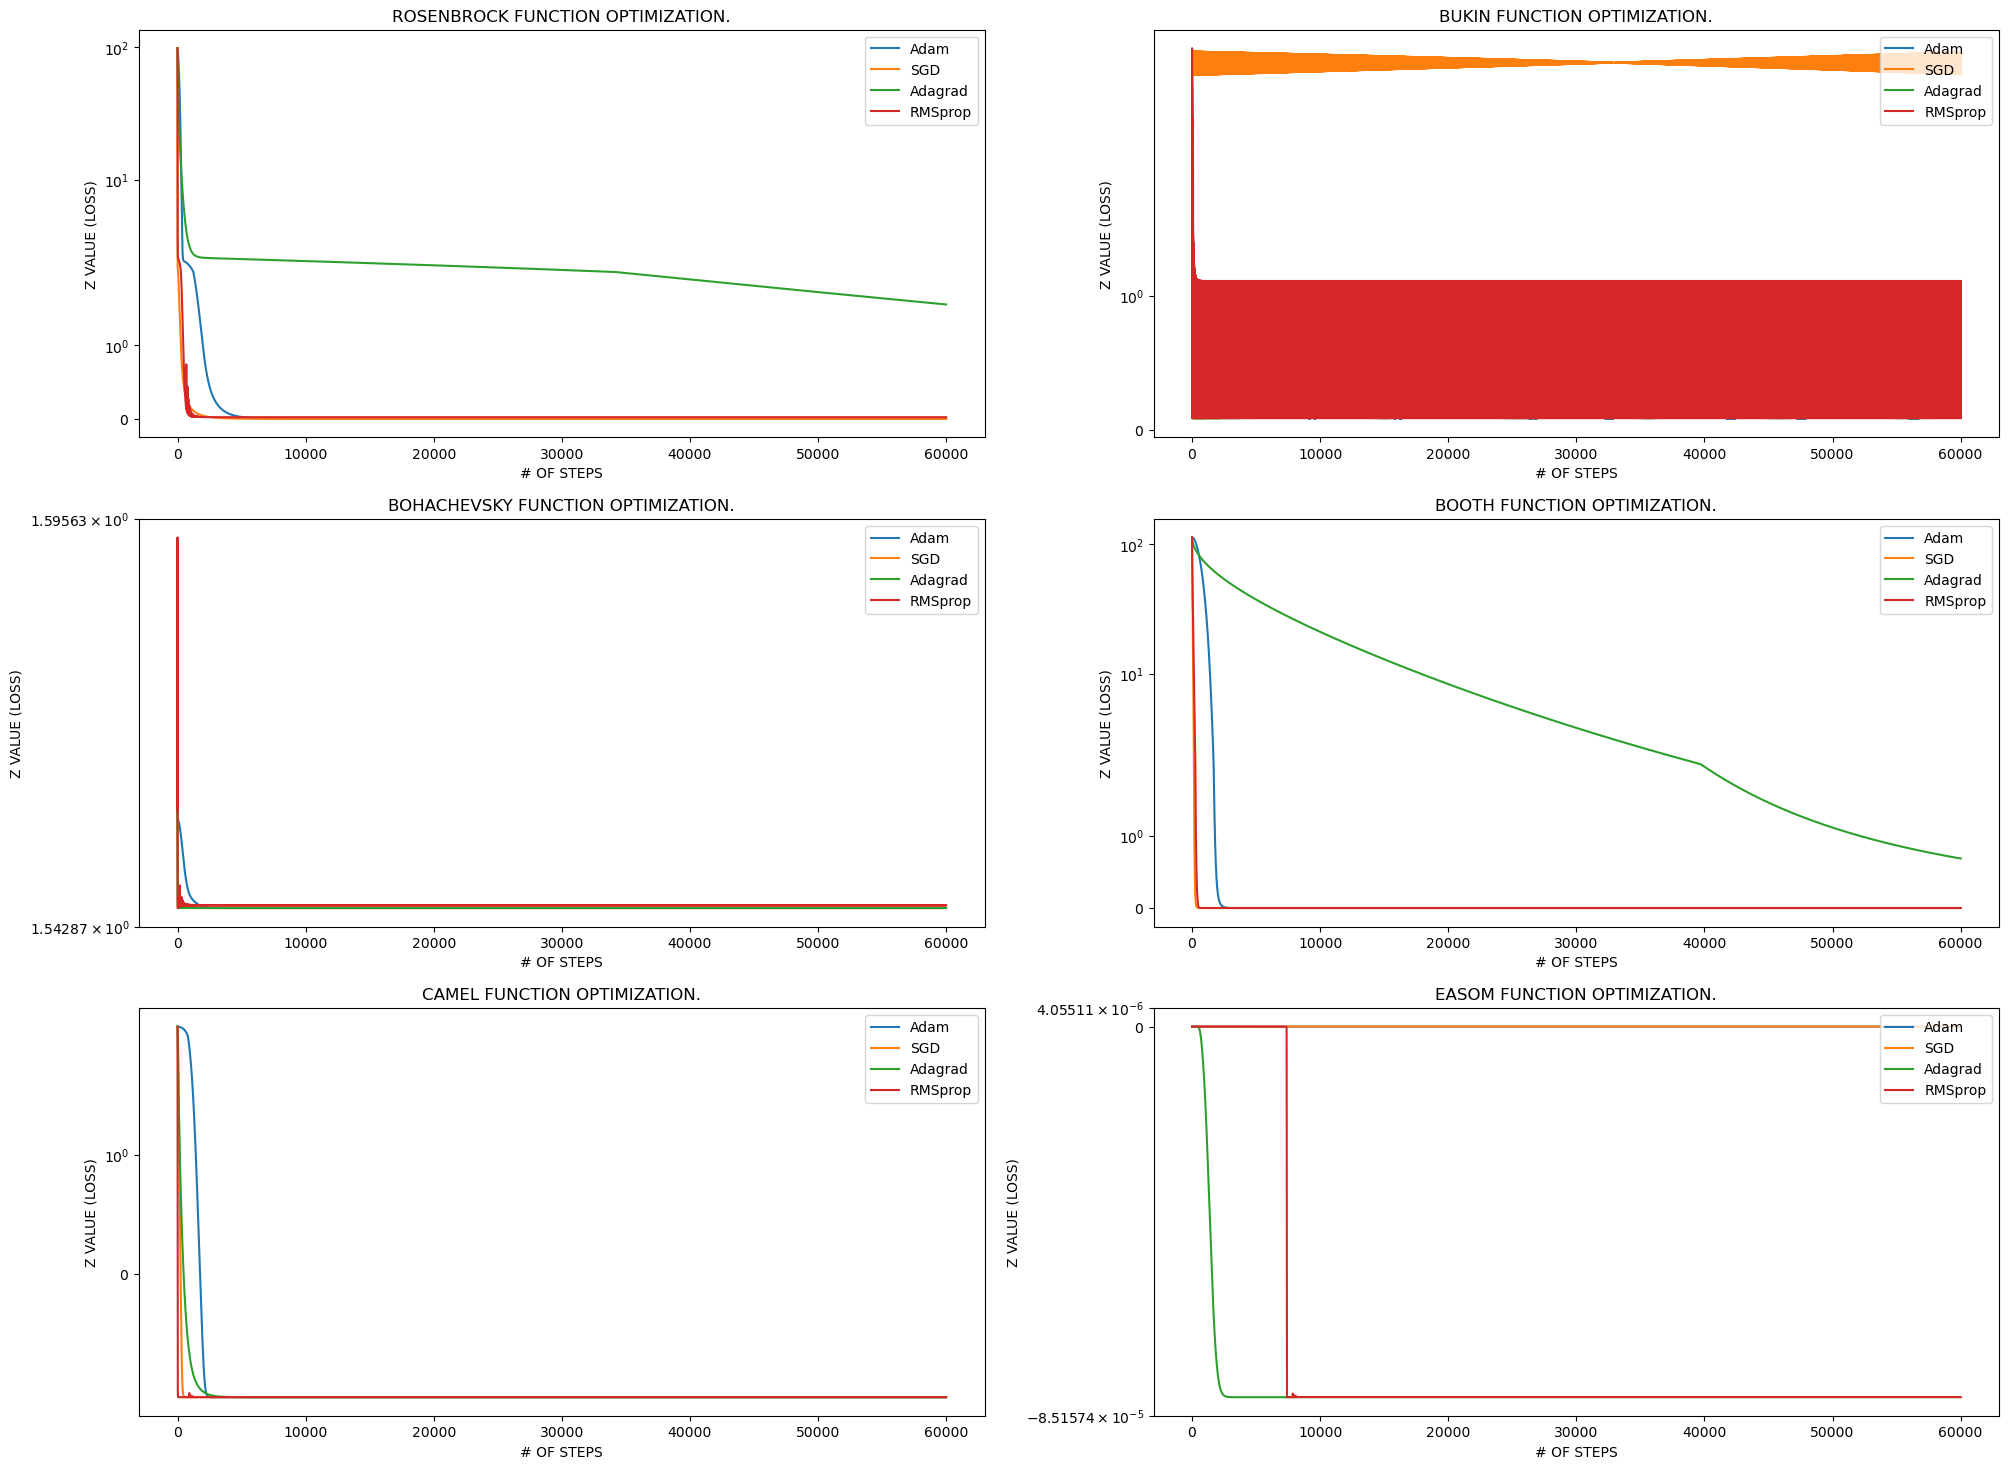

In [32]:
#Plot losses for each test function and compare to determine optimizer convergence speed and duration
#Import libraries
import matplotlib.pyplot as plt
%matplotlib inline

#Create subplot
loss_plot, [[Rosenbrock_ax, Bukin_ax], [Bohachevsky_ax, Booth_ax], [Camel_ax, Easom_ax]] = plt.subplots(3, 2, figsize = (24, 18))
#Function to plot losses for a particular objective function w.r.t all optimizers
def plotLosses(loss_func):
    #Iterate over each optimizer
    for optimizer in optimizers:
        #Plot optimizer's losses over the # of epochs
        globals()[loss_func + "_ax"].plot(optimizer_losses[optimizer][loss_func + "Loss"], label = optimizer)
    #Set title and x and y labels
    globals()[loss_func + "_ax"].set_title(loss_func.upper() + " FUNCTION OPTIMIZATION.")
    globals()[loss_func + "_ax"].set_xlabel("# OF STEPS")
    globals()[loss_func + "_ax"].set_ylabel("Z VALUE (LOSS)")
    #Display legend
    globals()[loss_func + "_ax"].legend(loc = "upper right")
    #Set to logarithmic scale to better see differences in updates as loss values become increasingly small
    globals()[loss_func + "_ax"].set_yscale("symlog")

#Plot losses for each loss function
for loss_func in loss_funcs:
    plotLosses(loss_func)